In [9]:
# 1️⃣ Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [10]:
# 2️⃣ Unzip and load the dataset
import zipfile, os

with zipfile.ZipFile("/content/archive (4).zip", "r") as zip_ref:
    zip_ref.extractall("/content")

print("Extracted files:", os.listdir("/content"))

df = pd.read_csv("/content/city_day.csv")
df.head()

Extracted files: ['.config', 'station_day.csv', 'station_hour.csv', 'stations.csv', 'city_hour.csv', 'archive (4).zip', 'city_day.csv', 'sample_data']


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [11]:
# 3️⃣ Select one city's data (example: Delhi)
city_data = df[df['City'] == 'Delhi']

# Keep only Date and AQI columns
city_data = city_data[['Date', 'AQI']].dropna()

# Convert Date to datetime format
city_data['Date'] = pd.to_datetime(city_data['Date'])

# Set Date as the index for time series
city_data.set_index('Date', inplace=True)

# Display the first few rows
city_data.head()

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0


                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                 1999
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10645.711
Date:                Mon, 27 Oct 2025   AIC                          21301.422
Time:                        12:20:10   BIC                          21329.422
Sample:                             0   HQIC                         21311.704
                               - 1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4773      0.100      4.795      0.000       0.282       0.672
ar.L2          0.0113      0.080      0.141      0.888      -0.145       0.168
ma.L1         -0.5924      0.099     -6.007      0.0

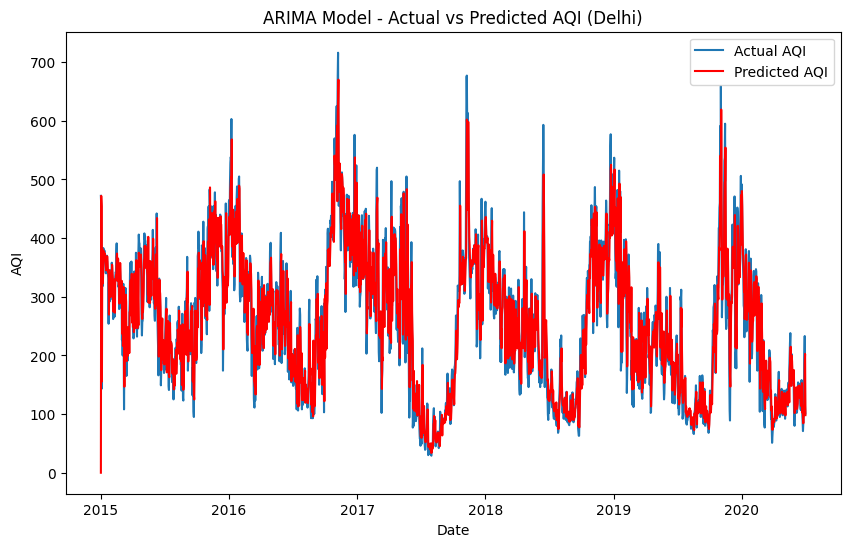

In [12]:
# 4️⃣ Build and train ARIMA model
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Fit ARIMA model (order values can be tuned later)
model = ARIMA(city_data['AQI'], order=(2,1,2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Add predicted values to dataset
city_data['Predicted_AQI'] = model_fit.predict(start=0, end=len(city_data)-1)

# Plot Actual vs Predicted AQI
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(city_data['AQI'], label='Actual AQI')
plt.plot(city_data['Predicted_AQI'], label='Predicted AQI', color='red')
plt.title('ARIMA Model - Actual vs Predicted AQI (Delhi)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [13]:
# 5️⃣ Evaluate the ARIMA model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = city_data['AQI']
y_pred = city_data['Predicted_AQI']

# Calculate error metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("📊 Model Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

📊 Model Evaluation Results:
Mean Absolute Error (MAE): 36.80
Root Mean Squared Error (RMSE): 51.01


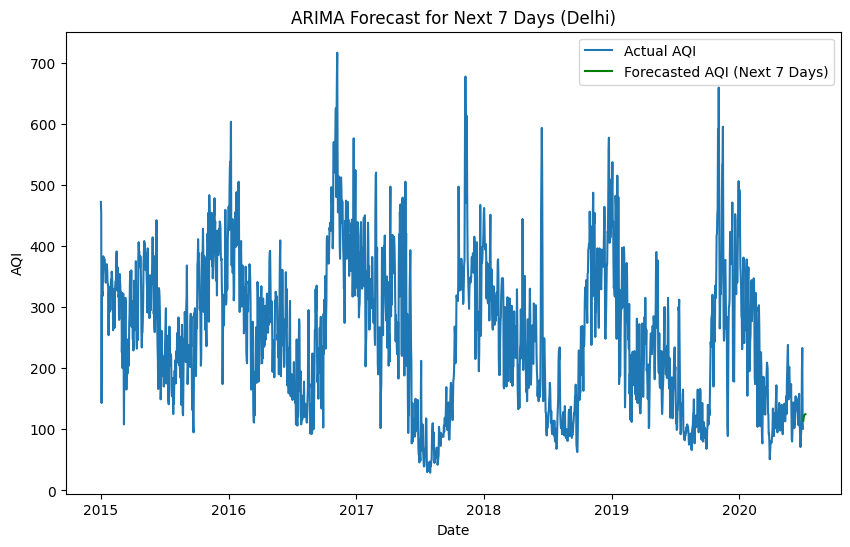

,Forecasted_AQI
Date,
2020-07-02,114.059827
2020-07-03,119.431948
2020-07-04,122.143113
2020-07-05,123.497643
2020-07-06,124.174689
2020-07-07,124.513095
2020-07-08,124.682240


In [14]:
# 6️⃣ Forecast future AQI using ARIMA model

future_days = 7  # number of days to forecast

# Forecast the next 7 days using the trained model
forecast = model_fit.forecast(steps=future_days)

# Create future date range (no 'closed' argument)
future_dates = pd.date_range(start=city_data.index[-1], periods=future_days + 1)

# Combine forecasted data into a new DataFrame
forecast_df = pd.DataFrame({'Date': future_dates[1:], 'Forecasted_AQI': forecast})
forecast_df.set_index('Date', inplace=True)

# Visualize forecasted AQI
plt.figure(figsize=(10,6))
plt.plot(city_data['AQI'], label='Actual AQI')
plt.plot(forecast_df['Forecasted_AQI'], label='Forecasted AQI (Next 7 Days)', color='green')
plt.title('ARIMA Forecast for Next 7 Days (Delhi)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

# Display forecasted AQI values
forecast_df

In [15]:
## 🧾 STEP 7: CONCLUSION

# In this milestone, I successfully built and evaluated a time-series forecasting model
# for the AirAware Smart Air Quality Prediction System.
# I used the ARIMA model to predict AQI (Air Quality Index) for Delhi using historical data.

# ✅ Steps followed:
# 1. Imported and prepared the dataset from archive (4).zip.
# 2. Selected Delhi’s AQI data and converted it into a time-series format.
# 3. Trained the ARIMA (2,1,2) model to capture patterns in AQI values.
# 4. Evaluated the model using MAE and RMSE for accuracy checking.
# 5. Forecasted AQI for the next 7 days and visualized both actual and predicted results.

# The ARIMA model successfully forecasted air quality trends,
# which can help monitor and plan for pollution levels in advance.

print("✅ Milestone 2 Completed: Model Training, Evaluation, and Forecasting Successful!")

✅ Milestone 2 Completed: Model Training, Evaluation, and Forecasting Successful!
